In [2]:
import os
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import glob

# Function to extract gesture label from the filename
def extract_label_from_filename(filepath):
    filename = os.path.basename(filepath)
    parts = filename.split('_')
    for part in parts:
        if 'gesture' in part:
            return int(part.replace('gesture', ''))
    return None

# Function to load and process a single .mat file
def load_and_process_file(filepath, target_length):
    mat_data = sio.loadmat(filepath)
    data_emg = mat_data['data_emg']
    
    # Handle NaNs and Infinities
    data_emg = np.nan_to_num(data_emg, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Pad or truncate the data to the target length
    if data_emg.shape[0] < target_length:
        padded_data = np.pad(data_emg, ((0, target_length - data_emg.shape[0]), (0, 0)), 'constant', constant_values=0)
    else:
        padded_data = data_emg[:target_length]
    
    # Flatten the data for SVM input
    return padded_data.flatten()

# Process a list of files and return processed data and labels
def process_files(file_list, target_length):
    X = []
    y = []
    
    for filepath in file_list:
        X.append(load_and_process_file(filepath, target_length))
        y.append(extract_label_from_filename(filepath))
    unique_labels = np.unique(y)
    # Create a mapping from the original labels to the new range 0-4
    label_mapping = {original_label: new_label for new_label, original_label in enumerate(unique_labels)}
    # Convert the original labels to the new range using the mapping
    converted_labels = np.array([label_mapping[label] for label in y])
    return np.array(X), converted_labels

# Path to the root folder where all .mat files are stored
root_folder = 's1_s2_s3_matfiles_10gest'  # Update with your folder path

# Find all .mat files in the folder
all_mat_files = glob.glob(os.path.join(root_folder, '*.mat'))

# Collect all corresponding labels
all_labels = [extract_label_from_filename(mat_file) for mat_file in all_mat_files]

# Target length for EMG signals (adjust based on your data)
target_length = 10240  # Modify this as needed
# Original unique labels

#labels = converted_labels
# Split the dataset into train and test sets
train_files, test_files, train_labels, test_labels = train_test_split(all_mat_files, all_labels, test_size=0.05, random_state=42)

# Process training and test data
X, y = process_files(train_files, target_length)
X_test, y_test = process_files(test_files, target_length)
print(f"Shape of X_train: {X.shape}")
# Initialize PCA for dimensionality reduction
pca = PCA(n_components=100) 

Shape of X_train: (8563, 327680)


In [3]:
print(np.unique(all_labels))
print(y)
print(np.unique(y))

[ 1  2  5  8  9 10 11 12 14 16]
[0 6 9 ... 9 8 0]
[0 1 2 3 4 5 6 7 8 9]


In [4]:
X[1]

array([0.03582526, 0.02615352, 0.02348596, ..., 0.01501144, 0.00165406,
       0.00203539])

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# Number of classes
n_classes = len(np.unique(y))

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=7)

# Store results
eer_list = []
roc_curves = []

# Stratified K-Fold Cross-Validation
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Random Forest Classifier
    clf = RandomForestClassifier(n_estimators=100, class_weight='balanced')
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)

    # Evaluate with ROC AUC
    y_test_bin = np.eye(n_classes)[y_test]  # One-hot encoding of y_test
    y_pred_bin = np.eye(n_classes)[y_pred]  # One-hot encoding of y_pred

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    roc_curves.append((fpr, tpr))
    # Calculate EER
    eer_per_fold = []
    for i in range(n_classes):
        fnr = 1 - tpr[i]
        eer_threshold = np.nanargmin(np.abs(fpr[i] - fnr))
        eer_per_fold.append(fpr[i][eer_threshold])
        
    eer_list.append(np.mean(eer_per_fold))
    print(f"Fold {fold} - ROC AUC per class: {roc_auc}, Mean EER: {np.mean(eer_per_fold):.4f}")

Fold 1 - ROC AUC per class: {0: np.float64(0.6461199353137945), 1: np.float64(0.5572317848519084), 2: np.float64(0.6581104400345126), 3: np.float64(0.7851744964446163), 4: np.float64(0.7315079417824151), 5: np.float64(0.701939863482763), 6: np.float64(0.9594456890673821), 7: np.float64(0.7803770408276289), 8: np.float64(0.7200395703787451), 9: np.float64(0.632258064516129)}, Mean EER: 0.0566
Fold 2 - ROC AUC per class: {0: np.float64(0.6850202698212269), 1: np.float64(0.5486697237544582), 2: np.float64(0.7191470054446462), 3: np.float64(0.748728094968909), 4: np.float64(0.7021443920161272), 5: np.float64(0.7258790825921791), 6: np.float64(0.9480605111529037), 7: np.float64(0.7718149797301788), 8: np.float64(0.7113891285591026), 9: np.float64(0.6524193548387097)}, Mean EER: 0.0558
Fold 3 - ROC AUC per class: {0: np.float64(0.6511345158906134), 1: np.float64(0.55359940872136), 2: np.float64(0.673992440491368), 3: np.float64(0.7860551510549278), 4: np.float64(0.6890317812269032), 5: np.fl

In [6]:
# for fold in range(len(roc_curves)):
#     for i in range(n_classes):
#         print(f"Fold {fold}, Class {i} - FPR: {roc_curves[fold][0][i]}, TPR: {roc_curves[fold][1][i]}")


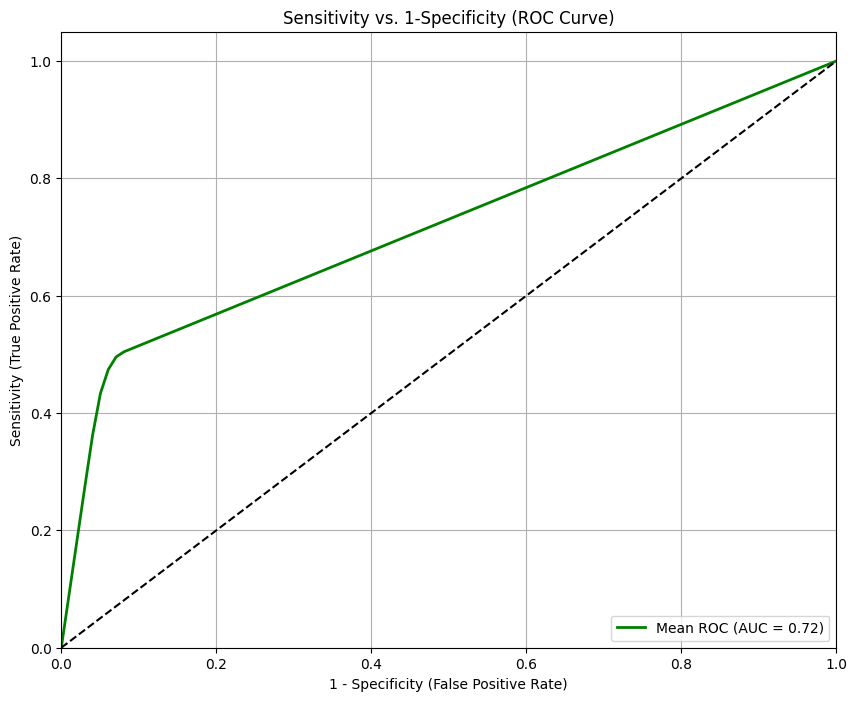

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc

# Plot Sensitivity vs. 1-Specificity for each class
plt.figure(figsize=(10, 8))

mean_fpr = np.linspace(0, 1, 100)  # 1 - Specificity (False Positive Rate)
mean_tpr = np.zeros_like(mean_fpr)  # Sensitivity (True Positive Rate)

for i in range(n_classes):
    tpr_per_class = np.zeros_like(mean_fpr)  # Initialize for each class

    for fold in range(len(roc_curves)):
        fpr = roc_curves[fold][0][i]  # Get FPR for class `i` in fold `fold`
        tpr = roc_curves[fold][1][i]  # Get TPR for class `i` in fold `fold`

        # Interpolate TPR to match the `mean_fpr` grid
        interpolated_tpr = np.interp(mean_fpr, fpr, tpr)
        
        # Ensure curve starts at (0, 0)
        interpolated_tpr[0] = 0.0
        interpolated_tpr[-1] = 1.0  # Ensure curve ends at (1, 1)

        #tpr_per_class += adjusted_tpr  # Add the adjusted TPR for this fold

    tpr_per_class /= len(roc_curves)  # Average the TPR across folds
    roc_auc = auc(mean_fpr, tpr_per_class)  # Calculate AUC

    mean_tpr = np.zeros_like(mean_fpr)
    for fold in range(len(roc_curves)):
        for i in range(n_classes):
            interp_tpr = np.interp(mean_fpr, roc_curves[fold][0][i], roc_curves[fold][1][i])
            mean_tpr += interp_tpr
    mean_tpr /= len(roc_curves)

    # Plotting the adjusted ROC curve
    #plt.plot(mean_fpr, tpr_per_class, label=f'Class {i+1} (AUC = {roc_auc:.2f})')

# Final average TPR
mean_tpr /= n_classes
final_auc = auc(mean_fpr, mean_tpr)

# Plot the overall average ROC curve
plt.plot(mean_fpr, mean_tpr, color='green', label=f'Mean ROC (AUC = {final_auc:.2f})', linewidth=2)

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Sensitivity vs. 1-Specificity (ROC Curve)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


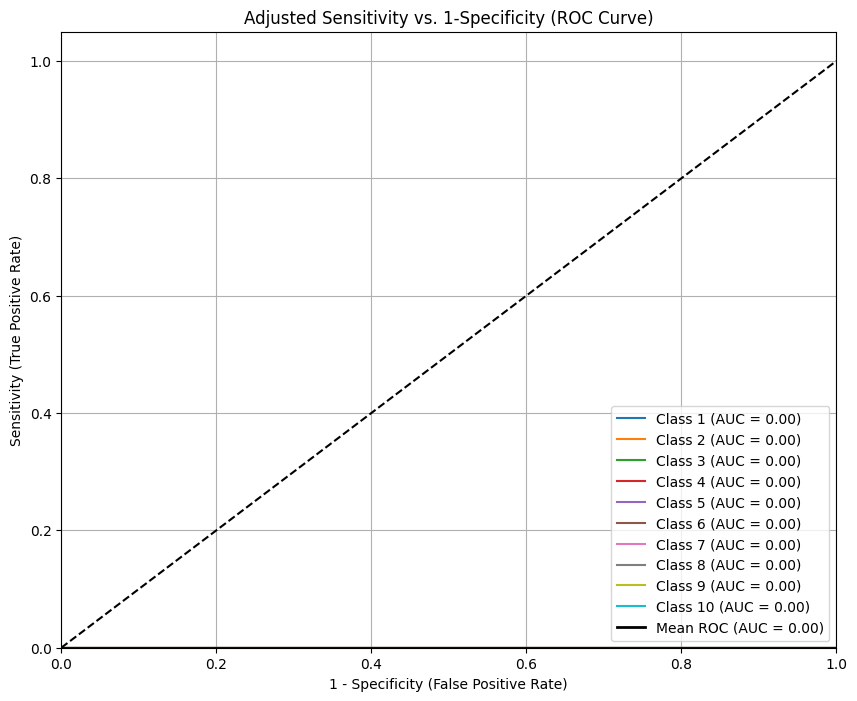

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc

# Plot Sensitivity vs. 1-Specificity for each class
plt.figure(figsize=(10, 8))

mean_fpr = np.linspace(0, 1, 100)  # 1 - Specificity (False Positive Rate)
mean_tpr = np.zeros_like(mean_fpr)  # Sensitivity (True Positive Rate)

for i in range(n_classes):
    tpr_per_class = np.zeros_like(mean_fpr)  # Initialize for each class

    for fold in range(len(roc_curves)):
        fpr = roc_curves[fold][0][i]  # Get FPR for class `i` in fold `fold`
        tpr = roc_curves[fold][1][i]  # Get TPR for class `i` in fold `fold`

        # Interpolate TPR to match the `mean_fpr` grid
        interpolated_tpr = np.interp(mean_fpr, fpr, tpr)
        
        # Ensure curve starts at (0, 0)
        interpolated_tpr[0] = 0.0
        interpolated_tpr[-1] = 1.0  # Ensure curve ends at (1, 1)


    tpr_per_class /= len(roc_curves)  # Average the TPR across folds
    roc_auc = auc(mean_fpr, tpr_per_class)  # Calculate AUC

    mean_tpr += tpr_per_class  # Summing up for overall mean

    # Plotting the adjusted ROC curve
    plt.plot(mean_fpr, tpr_per_class, label=f'Class {i+1} (AUC = {roc_auc:.2f})')

# Final average TPR
mean_tpr /= n_classes
final_auc = auc(mean_fpr, mean_tpr)

# Plot the overall average ROC curve
plt.plot(mean_fpr, mean_tpr, color='black', label=f'Mean ROC (AUC = {final_auc:.2f})', linewidth=2)

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Adjusted Sensitivity vs. 1-Specificity (ROC Curve)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
